## Code for pulling timeframe data for each stat

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random
from datetime import datetime, timedelta

import tqdm


In [1]:
data = pd.read_csv('pitch_by_pitch_data.csv')


# # https://github.com/jldbc/pybaseball/tree/master/docs
# from pybaseball import statcast
# from pybaseball import batting_stats_bref
# from pybaseball import statcast_running_splits
# from pybaseball import statcast_batter
# from pybaseball import playerid_lookup
# from pybaseball import batting_stats_range

# id = int(playerid_lookup('judge', 'aaron')['key_mlbam'])
# speeds = statcast_running_splits(2022, 50)
# print(speeds)
# hitter_stats = statcast_batter('2022-06-01', '2022-06-30', id)
# # hitter_stats.head(2)


def compute_PA_stats(data, n, timeframes):
    
    data_start_dt = datetime.strptime(data['game_date'].iloc[-1], '%Y-%m-%d').date()
    PAs = []
    # Transform data to only contain 1 row for each PA
    # for index, row in data.iterrows():
    #     if not pd.isnull(row['events'])  :
    #         # 'intentionally' in row['des']
    #     # if row['events'] in ['strikeout', 'field_error', 'field_out', 'single', 'double', 'triple', 'home_run', 'double_play', 'grounded_into_double_play', 'force_out', 'sac_fly', 'fielders_choice', 'walk', 'hit_by_pitch', 'triple_play']:
    #         PAs.append(row)
    PA_df = data.dropna(subset = ['events'])
    PA_stats = ['walk', 'strikeout', 'hit_by_pitch', 'ground_ball', 'fly_ball', 'line_drive', 'popup', 'xwoba']
    stats_dict = dict(zip(PA_stats, ([] for _ in PA_stats)))
    time_frame_stats = dict(zip(PA_stats, ([] for _ in PA_stats)))
    used_idx = []
    # Select random samples
    for i in tqdm.tqdm(range(n)):
        idx = random.randint(0, len(PA_df))
        counter = 0
        while (idx in used_idx or datetime.strptime(PA_df['game_date'].iloc[idx], '%Y-%m-%d').date() < data_start_dt + timedelta(days=timeframes[-1])):
            counter +=1 
            idx =  (idx+1) % len(PA_df)
            if counter == len(PA_df):
                return concatenate_PA_data(time_frame_stats, stats_dict, PA_stats) 
            

        used_idx.append(idx)
        id = int(PA_df['batter'].iloc[idx])
 
        # id = int(playerid_lookup(last_nm, first_nm)['key_mlbam'])
        date = datetime.strptime(PA_df['game_date'].iloc[idx], '%Y-%m-%d').date()
        player_data = PA_df[PA_df['batter'].astype(int) == id]
        timeframe_data = []
        for index, row in player_data.iterrows():
            if datetime.strptime(row['game_date'], '%Y-%m-%d').date() < date:
                timeframe_data.append(row)
        player_timeframe_data = pd.DataFrame(timeframe_data)

       
        stats_dict = find_PA_outcome(stats_dict, PA_df, idx)
        
        for stat in stats_dict:
            time_frame_stats[stat].append(find_PA_time_stats(player_timeframe_data, stat, timeframes, date))
    return concatenate_PA_data(time_frame_stats, stats_dict, PA_stats)
def concatenate_PA_data(time_frame_stats, stats_dict, PA_stats):
    PA_data = dict(zip(PA_stats, ([] for _ in PA_stats)))
    for stat in PA_stats:
        
        PA_stat_data = []
        for i in range (n):
            data_row = time_frame_stats[stat][i]
            data_row.append(stats_dict[stat][i])
            
            PA_stat_data.append(data_row)
        PA_data[stat] = PA_stat_data
    return(PA_data)
def find_PA_outcome(stats_dict, PA_df, idx):
    for stat in stats_dict:
        # Find outcome of PA for stat
        if stat in ['walk', 'strikeout', 'hit_by_pitch']:
            if PA_df['events'].iloc[idx] == stat:
                stats_dict[stat].append(1)
            else:
                stats_dict[stat].append(0)
        elif stat in ['ground_ball', 'fly_ball', 'line_drive', 'popup'] :
            if not pd.isnull(PA_df['bb_type'].iloc[idx]):
                if PA_df['bb_type'].iloc[idx] == stat:
                    stats_dict[stat].append(1)
                else:
                    stats_dict[stat].append(0)
            else:
                stats_dict[stat].append(0)
        else:
            if not pd.isnull(PA_df['estimated_woba_using_speedangle'].iloc[idx]):
                stats_dict[stat].append(PA_df['estimated_woba_using_speedangle'].iloc[idx])
            else:
                stats_dict[stat].append(PA_df['woba_value'].iloc[idx])
    return stats_dict
def find_PA_time_stats(player_timeframe_data, stat, time_frames, date):
    time_frame_stat_ctr = dict(zip(time_frames, (0 for _ in time_frames)))
    time_frame_PA_ctr = dict(zip(time_frames, (0 for _ in time_frames)))
    for timeframe in time_frames:
        start_dt =  date - timedelta(days=timeframe)
        for index, row in player_timeframe_data.iterrows():
            if datetime.strptime(row['game_date'], '%Y-%m-%d').date() >= start_dt:
                time_frame_PA_ctr[timeframe] += 1
                if stat in ['walk', 'strikeout', 'hit_by_pitch']:
                    if row['events'] == stat:
                        time_frame_stat_ctr[timeframe] += 1
                elif stat in ['ground_ball', 'fly_ball', 'line_drive', 'popup'] :
                    if not pd.isnull(row['bb_type']):
                        if row['bb_type'] == stat:
                            time_frame_stat_ctr[timeframe] += 1
                else:
                    if not pd.isnull(row['estimated_woba_using_speedangle']):
                        time_frame_stat_ctr[timeframe] += row['estimated_woba_using_speedangle']
                    else:
                        time_frame_stat_ctr[timeframe] += row['woba_value']
    time_frame_stats = []
    for time in time_frames:
        if time_frame_PA_ctr[time] == 0:
            time_frame_stats.append(0)
        else:
            time_frame_stats.append(time_frame_stat_ctr[time]/time_frame_PA_ctr[time])
    return time_frame_stats
def compute_bb_stats(data, n, timeframes):
    bb_df = data.dropna(subset = ['type', 'launch_speed', 'launch_angle'])
    bb_df = bb_df[bb_df['type'] == 'X']
    bb_stats = ['launch_speed', 'launch_angle']
    stats_dict = dict(zip(bb_stats, ([] for _ in bb_stats)))
    data_start_dt = datetime.strptime(bb_df['game_date'].iloc[-1], '%Y-%m-%d').date()
    time_frame_stats = dict(zip(bb_stats, ([] for _ in bb_stats)))

    used_idx = []
    for i in tqdm.tqdm(range(n)):
    
        idx = random.randint(0, len(bb_df))
        counter = 0
        while (idx in used_idx or datetime.strptime(bb_df['game_date'].iloc[idx], '%Y-%m-%d').date() < data_start_dt + timedelta(days=timeframes[-1])):
            counter +=1 
            idx =  (idx+1) % len(bb_df)
            if counter == len(bb_df):
                return concatenate_PA_data(time_frame_stats, stats_dict, bb_stats) 

        used_idx.append(idx)
        id = int(bb_df['batter'].iloc[idx])
        date = datetime.strptime(bb_df['game_date'].iloc[idx], '%Y-%m-%d').date()
        player_data = bb_df[bb_df['batter'].astype(int) == id]
        timeframe_data = []
        for index, row in player_data.iterrows():
            if datetime.strptime(row['game_date'], '%Y-%m-%d').date() < date:
                timeframe_data.append(row)
        player_timeframe_data = pd.DataFrame(timeframe_data)
        
        stats_dict = find_bb_outcome(stats_dict, bb_df, idx)
        for stat in bb_stats:
            time_frame_stats[stat].append(find_bb_time_stats(player_timeframe_data, stat, timeframes, date))
    return concatenate_bb_data(bb_stats, time_frame_stats, stats_dict)
def concatenate_bb_data(bb_stats, time_frame_stats, stats_dict):
    bb_data = dict(zip(bb_stats, ([] for _ in bb_stats)))
    for stat in bb_stats:
        
        bb_stat_data = []
        for i in range (n):
            data_row = time_frame_stats[stat][i]
            data_row.append(stats_dict[stat][i])
            
            bb_stat_data.append(data_row)
        bb_data[stat] = bb_stat_data
    return(bb_data)
def find_bb_outcome(stats_dict, bb_df, idx):
    stats_dict['launch_speed'].append(bb_df['launch_speed'].iloc[idx])
    stats_dict['launch_angle'].append(bb_df['launch_angle'].iloc[idx])
    return stats_dict
def find_bb_time_stats(player_timeframe_data, stat, time_frames, date):
    time_frame_stat_ctr = dict(zip(time_frames, (0 for _ in time_frames)))
    time_frame_PA_ctr = dict(zip(time_frames, (0 for _ in time_frames)))
    for timeframe in time_frames:
        start_dt =  date - timedelta(days=timeframe)
        for index, row in player_timeframe_data.iterrows():
            if datetime.strptime(row['game_date'], '%Y-%m-%d').date() >= start_dt:
                time_frame_PA_ctr[timeframe] += 1
                time_frame_stat_ctr[timeframe] += row[stat]
    time_frame_stats = []
    for time in time_frames:
        if time_frame_PA_ctr[time] == 0:
            time_frame_stats.append(0)
        else:
            time_frame_stats.append(time_frame_stat_ctr[time]/time_frame_PA_ctr[time])
    return time_frame_stats

timeframes = [1, 15, 30, 60]
n = 10000
print('Generating PA data...')
PA_data = compute_PA_stats(data, n, timeframes)
print('Generating BB data...')
bb_data = compute_bb_stats(data, n, timeframes)

Generating PA data...


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [6:00:39<00:00,  1.14s/it]


Generating BB data...


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [2:34:12<00:00,  2.33it/s]


In [2]:
names = ['walk', 'strikeout', 'hit_by_pitch', 'ground_ball', 'fly_ball', 'line_drive', 'popup', 'xwoba']
for name in names:
    print(name)
    curr_data = PA_data[name]
    curr_df = pd.DataFrame(curr_data, columns=['One', 'Fifteen', 'Thirty', 'Sixty', 'Result'])
    
    curr_df.to_csv(name + '.csv')

walk
strikeout
hit_by_pitch
ground_ball
fly_ball
line_drive
popup
xwoba


In [3]:
names = ['launch_speed', 'launch_angle']
for name in names:
    print(name)
    curr_data = bb_data[name]
    curr_df = pd.DataFrame(curr_data, columns=['One', 'Fifteen', 'Thirty', 'Sixty', 'Result'])
    
    curr_df.to_csv(name + '.csv')

launch_speed
launch_angle


## Load timeframe data, run regressions

In [8]:
walk = pd.read_csv('walk.csv', index_col=0)
strikeout = pd.read_csv('strikeout.csv', index_col=0)
hit_by_pitch = pd.read_csv('hit_by_pitch.csv', index_col=0)
ground_ball = pd.read_csv('ground_ball.csv', index_col=0)
fly_ball = pd.read_csv('fly_ball.csv', index_col=0)
line_drive = pd.read_csv('line_drive.csv', index_col=0)
popup = pd.read_csv('popup.csv', index_col=0)
xwoba = pd.read_csv('xwoba.csv', index_col=0)

In [38]:
walk  = walk.drop(walk.columns[[1, 3, 5, 7, 9, 11, 13, 15]],axis = 1)
strikeout  = strikeout.drop(strikeout.columns[[1, 3, 5, 7, 9, 11, 13, 15]],axis = 1)
hit_by_pitch  = hit_by_pitch.drop(hit_by_pitch.columns[[1, 3, 5, 7, 9, 11, 13, 15]],axis = 1)
ground_ball  = ground_ball.drop(ground_ball.columns[[1, 3, 5, 7, 9, 11, 13, 15]],axis = 1)
fly_ball  = fly_ball.drop(fly_ball.columns[[1, 3, 5, 7, 9, 11, 13, 15]],axis = 1)
line_drive  = line_drive.drop(line_drive.columns[[1, 3, 5, 7, 9, 11, 13, 15]],axis = 1)
popup  = popup.drop(popup.columns[[1, 3, 5, 7, 9, 11, 13, 15]],axis = 1)
xwoba  = xwoba.drop(xwoba.columns[[1, 3, 5, 7, 9, 11, 13, 15]],axis = 1)



In [4]:
launch_speed = pd.read_csv('launch_speed.csv', index_col=0)
launch_angle = pd.read_csv('launch_angle.csv', index_col=0)

In [41]:
line_drive

,p7,h7,p15,h15,p45,h45,p90,h90,Result
0,0.130435,0.142857,0.186047,0.140845,0.172662,0.175141,0.209302,0.186047,0
1,0.181818,0.250000,0.192308,0.196721,0.125000,0.202614,0.137681,0.176259,1
2,0.095238,0.290323,0.095238,0.241935,0.095238,0.203390,0.113990,0.166667,0
3,0.000000,0.111111,0.000000,0.066667,0.000000,0.114754,0.165049,0.092105,0
4,0.111111,0.166667,0.104167,0.204545,0.123596,0.153846,0.128378,0.173502,0
...,...,...,...,...,...,...,...,...,...
9995,0.148148,0.375000,0.094340,0.160000,0.148718,0.163121,0.158088,0.170068,1
9996,0.000000,0.181818,0.150000,0.174603,0.233333,0.174699,0.206522,0.186335,0
9997,0.176471,0.105263,0.176471,0.127660,0.176471,0.204082,0.206897,0.174216,0
9998,0.200000,0.000000,0.045455,0.130435,0.040000,0.157895,0.040000,0.177083,0


## Logistic Regression

In [10]:
log_stats = [walk, strikeout, hit_by_pitch, ground_ball, fly_ball, line_drive, popup]
# log_stats = [strikeout, ground_ball, fly_ball, line_drive, popup]
log_stat_names = ['walk', 'strikeout', 'hit_by_pitch', 'ground_ball', 'fly_ball', 'line_drive', 'popup']

In [37]:
for idx, stat in enumerate(log_stats):
    print('Logistic Regression for ' + log_stat_names[idx] + '...')
    stat2 = stat.drop(stat.columns[[1, 3, 5, 7, 9, 11, 13, 15]],axis = 1)
    
    X = stat2.drop(['Result'], axis=1)
    y = stat2['Result']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=12)
    
    clf = LogisticRegression(solver='newton-cg', max_iter = 1000, penalty = 'l2').fit(X_train, y_train)
    print('Coefficients: ', end='')
    print(clf.coef_)
    print('Score: ', end='')
    print(clf.score(X_test, y_test))
    # print('Sample Prediction: ', end='')
    # print(clf.predict_proba(np.array([[0.000000, 0.277800, 0.236824, 0.277804]])))
    
    predictions = clf.predict_proba(X_test)
    predictions_1 = []
    for elem in predictions:
        predictions_1.append(elem[1])
        

    print('MSE: ', end='')
    print(mean_squared_error(y_test, predictions_1))
    print('--------------------------------------------------------------------------------------')

Logistic Regression for walk...
Logistic Regression for strikeout...
Logistic Regression for hit_by_pitch...
Logistic Regression for ground_ball...
Logistic Regression for fly_ball...
Logistic Regression for line_drive...
Logistic Regression for popup...


## PCA

In [17]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

PCA for walk...


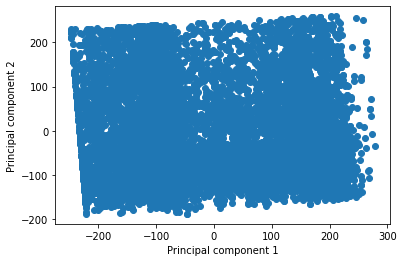

PCA for strikeout...


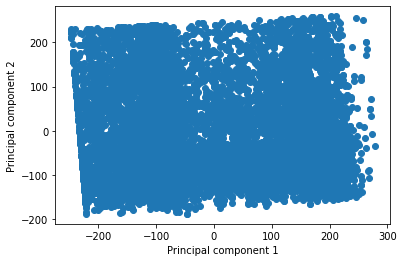

PCA for hit_by_pitch...


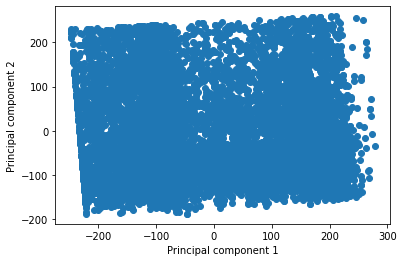

PCA for ground_ball...


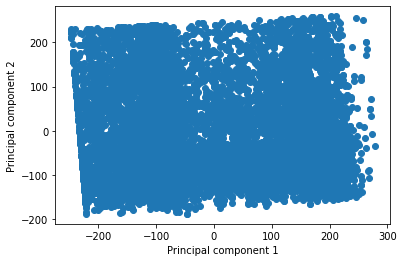

PCA for fly_ball...


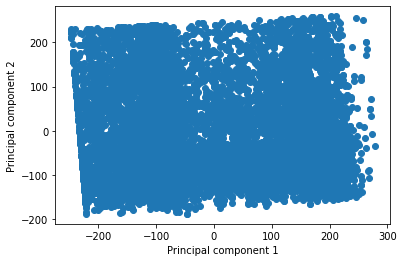

PCA for line_drive...


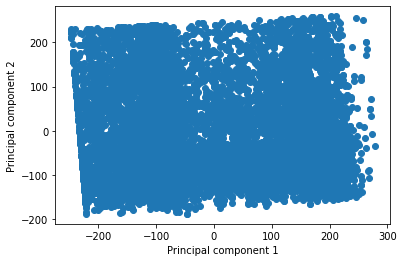

PCA for popup...


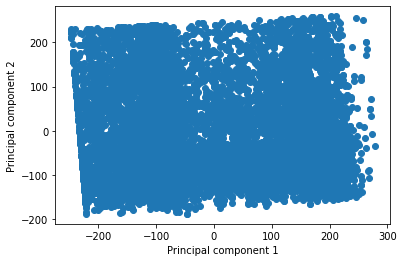

In [18]:
for idx, stat in enumerate(log_stats):
    print('PCA for ' + log_stat_names[idx] + '...')
    
    X = stat.drop(['Result'], axis=1)
    y = stat['Result']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=12)
    
    # fit PCA
    pca = PCA()
    pca.fit(X)
    k = 3
    # get the principal components (n_components is the number of components to keep)
    components = pca.fit_transform(X)[:, :k]
    component1 = components[:,0]
    component2 = components[:,1]
    
    
    # plot the components
    plt.scatter(components[:, 0], components[:, 1])
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.show()

## KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import math

KNN for walk...
8
Accuracy Scores : [0.855, 0.899, 0.909, 0.9135, 0.9145, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155, 0.9155]
MSE :  [0.14500000000000002, 0.10099999999999998, 0.09099999999999997, 0.08650000000000002, 0.08550000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002, 0.08450000000000002]
Best value of k is  11


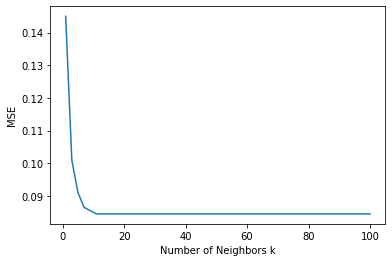

KNN for strikeout...
36
Accuracy Scores : [0.6385, 0.6885, 0.721, 0.725, 0.741, 0.745, 0.749, 0.754, 0.754, 0.759, 0.7575, 0.7585, 0.76, 0.7595, 0.759, 0.759, 0.7585, 0.7595, 0.7595, 0.7595, 0.76]
MSE :  [0.36150000000000004, 0.3115, 0.279, 0.275, 0.259, 0.255, 0.251, 0.246, 0.246, 0.241, 0.24250000000000005, 0.24150000000000005, 0.24, 0.24050000000000005, 0.241, 0.241, 0.24150000000000005, 0.24050000000000005, 0.24050000000000005, 0.24050000000000005, 0.24]
Best value of k is  25


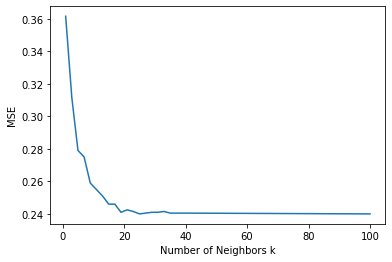

KNN for hit_by_pitch...
3
Accuracy Scores : [0.98, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875, 0.9875]
MSE :  [0.020000000000000018, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956, 0.012499999999999956]
Best value of k is  3


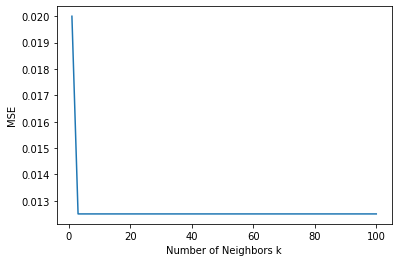

KNN for ground_ball...
62
Accuracy Scores : [0.568, 0.609, 0.637, 0.6625, 0.672, 0.6805, 0.6745, 0.683, 0.6885, 0.692, 0.6935, 0.7005, 0.701, 0.702, 0.7035, 0.7035, 0.7035, 0.7025, 0.7045, 0.7055, 0.7075]
MSE :  [0.43200000000000005, 0.391, 0.363, 0.3375, 0.32799999999999996, 0.3195, 0.3255, 0.31699999999999995, 0.3115, 0.30800000000000005, 0.3065, 0.2995, 0.29900000000000004, 0.29800000000000004, 0.2965, 0.2965, 0.2965, 0.2975, 0.2955, 0.2945, 0.2925]
Best value of k is  100


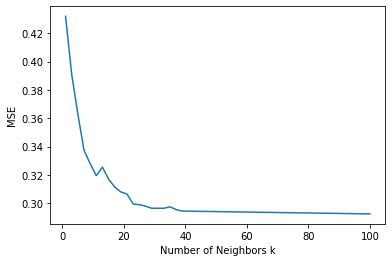

KNN for fly_ball...
35
Accuracy Scores : [0.71, 0.7665, 0.7955, 0.8055, 0.8115, 0.8145, 0.816, 0.8175, 0.818, 0.819, 0.819, 0.819, 0.8185, 0.8185, 0.819, 0.819, 0.819, 0.819, 0.819, 0.819, 0.819]
MSE :  [0.29000000000000004, 0.23350000000000004, 0.20450000000000002, 0.1945, 0.1885, 0.1855, 0.18400000000000005, 0.1825, 0.18200000000000005, 0.18100000000000005, 0.18100000000000005, 0.18100000000000005, 0.1815, 0.1815, 0.18100000000000005, 0.18100000000000005, 0.18100000000000005, 0.18100000000000005, 0.18100000000000005, 0.18100000000000005, 0.18100000000000005]
Best value of k is  19


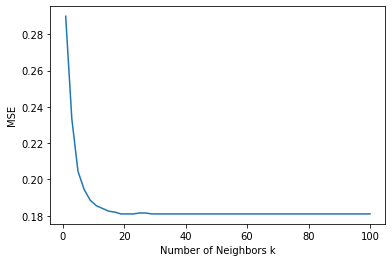

KNN for line_drive...
22
Accuracy Scores : [0.7375, 0.7795, 0.805, 0.8115, 0.819, 0.823, 0.825, 0.825, 0.826, 0.826, 0.8265, 0.8265, 0.8265, 0.8265, 0.8265, 0.8265, 0.8265, 0.8265, 0.8265, 0.8265, 0.8265]
MSE :  [0.26249999999999996, 0.22050000000000003, 0.19499999999999995, 0.1885, 0.18100000000000005, 0.17700000000000005, 0.17500000000000004, 0.17500000000000004, 0.17400000000000004, 0.17400000000000004, 0.1735, 0.1735, 0.1735, 0.1735, 0.1735, 0.1735, 0.1735, 0.1735, 0.1735, 0.1735, 0.1735]
Best value of k is  21


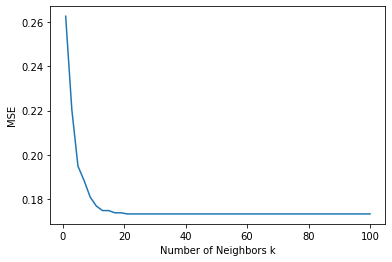

KNN for popup...
7
Accuracy Scores : [0.917, 0.945, 0.9495, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951, 0.951]
MSE :  [0.08299999999999996, 0.05500000000000005, 0.05049999999999999, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044, 0.049000000000000044]
Best value of k is  7


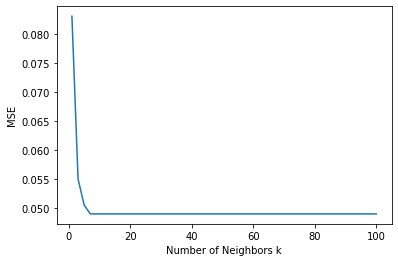

In [45]:
possible_k=[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39, math.floor(math.sqrt(10000))]
for idx, stat in enumerate(log_stats):
    print('KNN for ' + log_stat_names[idx] + '...')
    
    X = stat.drop(['Result'], axis=1)
    y = stat['Result']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=12)
    
    ac_scores=[]
    for k in possible_k:
        knn=KNeighborsClassifier(n_neighbors= k,weights = 'distance',metric="euclidean" )
        knn.fit(X_train,y_train)
        y_pred=knn.predict(X_test)
        onect = 0
        ct = 0
        # for pred in y_pred:
        #     if pred == 1:
        #         onect +=1
        #     ct +=1
        # print(onect/ct)
        scores=accuracy_score(y_test,y_pred)
        
        ac_scores.append(scores)
    print(np.count_nonzero(y_pred == 1))
    print ("Accuracy Scores :",ac_scores)
    MSE=[1-x for x in ac_scores]
    print ("MSE : ",MSE)

    i=MSE.index(min(MSE))
    best_k=possible_k[i]
    print ("Best value of k is ",best_k)
    plt.plot(possible_k,MSE)
    plt.xlabel("Number of Neighbors k")
    plt.ylabel("MSE")
    plt.show()

Linear Regression

In [28]:
import pandas as pd
from sklearn import linear_model

In [42]:
datasets = [walk, strikeout, hit_by_pitch, ground_ball, fly_ball, line_drive, popup]
for dataset in datasets:
    # split dataset into features and target
    X = dataset.iloc[:,:-1] # features
    y = dataset.iloc[:,-1] # target

    # create linear regression model
    model = linear_model.LinearRegression()

    # train the model on the dataset
    model.fit(X, y)

    # print model coefficients
    
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    print("R^2:", model.score(X, y))

Coefficients: [-0.02775699  0.04079437 -0.00918886  0.14243174  0.11475104  0.01710312
  0.29921043  0.3265366 ]
Intercept: 0.006762100034423069
R^2: 0.00878997839143203
Coefficients: [ 0.06383708 -0.06013879 -0.08111915  0.09988279  0.08513578 -0.16134007
  0.3640918   0.70592384]
Intercept: 0.00394663738987408
R^2: 0.018105948434318342
Coefficients: [-0.031026    0.0200933  -0.17528973  0.04335591  0.33768609 -0.05668612
  0.06089963  0.25902204]
Intercept: 0.005335312395341709
R^2: 0.0037554523018016317
Coefficients: [-0.02532153  0.03986209 -0.01530156 -0.03121436  0.12558288 -0.03613762
  0.32977879  0.56264262]
Intercept: 0.018553333422667462
R^2: 0.013824425012931019
Coefficients: [ 0.00199405 -0.02234633 -0.05676278  0.07816495 -0.10729101 -0.01332499
  0.45773515  0.30775003]
Intercept: 0.05844321861816472
R^2: 0.004693327037449957
Coefficients: [ 0.00139577  0.01184123  0.00665391  0.07522224  0.00631981 -0.07851838
  0.11892356  0.17703228]
Intercept: 0.11128271475197367
R^2

In [71]:
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# list of algorithms
# algorithms = [LogisticRegression(), KNeighborsClassifier(n_neighbors=30), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]
algorithms = [DecisionTreeClassifier()]
# load dataset
datasets = [walk, strikeout, hit_by_pitch, ground_ball, fly_ball, line_drive, popup]

# iterate over algorithms
for algorithm in algorithms:
    for data in datasets:
        # split dataset into features and target
        X = data.drop(['Result'], axis=1)
        y = data['Result']
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=20)
        # train the model
        model = algorithm.fit(X_train, y_train)

        # make predictions
        preds = model.predict(X_test)
        predictions = np.array(model.predict_proba(X_test))
        prob_pred = []
        for pred in predictions:
            prob_pred.append(pred[1])
        prob_pred = np.array(prob_pred)
        print(prob_pred[:50])
        
        # print accuracy
        print([x for x in globals() if globals()[x] is data][0])
        print(algorithm.__class__.__name__, metrics.accuracy_score(y_test, preds))
        print(np.mean(np.abs(y_test - prob_pred)))
        print(np.count_nonzero(preds == 1))
        print(np.count_nonzero(y_test == 1))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0.]
___
DecisionTreeClassifier 0.8455
0.1606
161
176
[0.  0.  1.  0.  0.  1.  0.5 1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.
 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.
 1.  0.  0.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0. ]
__
DecisionTreeClassifier 0.6405
0.3626666666666667
470
449
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00672646 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
hit_by_pitch
DecisionTreeClassifier 0.9